# **Sentiment notebook, Project SGI**
(OBS haps fra music project)

The purpose of sentiment analysis in our study is to get insights into the emotional part of the movies. 

First, the overall picture and investigate the distribution of sentiment, revealing whether the highest rated movies provides a positive or negative message. 

To get a deeper insight the sentiment of each genre is investigated with the aim of revealing if some genres are more more violent/negative than others. 

Furthermore, the study will include an evaluation of the models performance of classifying the sentiment of the songs. 

In the end we look into the most positive and negative songs and what words that describes the sentiment groups so as to achieve an understanding of what makes a movie negative/positive. 

Hopefully this part of our study will provide knowledge of the emotional state of movies and how the genres differentiates on their sentiment.

With an aim of exploring what makes a movie more succesful?
Can a movie be successful and have a really sad plot? Is it necessary? 
A movie with an average sentiment plot is that a successful movie?

### **Loading Packages**

In [172]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from collections import Counter
from fa2 import ForceAtlas2
from DataCleaningFunctions import DataCleaner, DataCollection, DataProcesser
import os
import json
import os
import re
import requests
from urllib.parse import quote, unquote
import collections
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import os
import math
from wordcloud import WordCloud, ImageColorGenerator
import random
import numpy as np

In [93]:
# nltk library
from nltk.corpus import PlaintextCorpusReader # from book
import nltk
import string
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
# Sentiment packages
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.express as px
# Initialize NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') # Need this to avoid error

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### **Define Colors**

In [165]:
color_palette_cividis = sns.color_palette("cividis", 40)
color_palette_plasma = sns.color_palette("plasma", 40)
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
colorpalette = color_palette_plasma + color_palette_cividis_reversed
two_colors = colorpalette[::8][0:2]
three_ratings_colors = colorpalette[::6][0:3]
three_different_colors = colorpalette[::10][0:3]
three_sentiment_colors = colorpalette[20::10][0:3]
genre_colors = colorpalette[::7][0:8]

hex_colors_genre = ['#1d068d', '#6700a7', '#a51f97', '#d3516f', '#f38649', '#fdc427', '#ecd54a', '#bcae6b']
# plt.figure(figsize = (20,2))
# plt.imshow([genre_colors])
# plt.axis('off')
# plt.show()

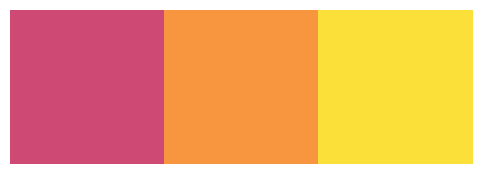

In [205]:
plt.figure(figsize = (20,2))
plt.imshow([three_sentiment_colors])
plt.axis('off')
plt.show()

## **Collect the Movie Plots using Wikipedia API**

In [3]:
# Import the dataframe
data = pd.read_json('df_movies.json',orient='table')
data = data.reset_index(drop=True)

In [ ]:
# Import the dataframe including the ratings
data_ratings = pd.read_json('df_movies_ratings.json',orient='table')
data_ratings = data_ratings.reset_index(drop=True)

In [103]:
def remove_comments(text):
    """
    Remove all comments from the wikicontent, so only the plot remains
    """
    return re.sub(r'<!--.*?-->', '', text)

def clean_filename(filename):
    """
    Replace non-alphanumeric characters (except underscores) with underscores
    """
    return re.sub(r'[^a-zA-Z0-9_]', '_', filename)

def get_wikipedia_content(title):
    """
    For the #redirect use these params instead.
    """
    base_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "revisions",
        "rvprop": "content"}
    
    response = requests.get(base_url, params=params)
    data = response.json()
    page = next(iter(data["query"]["pages"].values()))
    content = page.get("revisions", [{}])[0].get("*", "")
    return content

def contains_redirect(content):
    """
    In case of the lower case #REDIRECT
    """
    return "#redirect" in content.lower()

def resolve_redirects(content):
    """
    In case of #redirect/#REDIRECT in the extracted wikicontent.
    """
    while contains_redirect(content):
        # Extract the target page from the redirect content
        target_title = content.split("[[", 1)[-1].split("]]")[0]
        content = get_wikipedia_content(target_title)
    return content

def get_plot_text(wiki_content):
    """
    Extract only the plot text from the found wikicontent.
    """
    wiki_content_without_comments = remove_comments(wiki_content)
    plot_section_match = re.search(r'==\s*Plot\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    plot_section_match
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Plot summary\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Summary\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Story\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Synopsis\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Premise\s*==\s*(.*?)(==|\Z)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    if plot_section_match is None:
        plot_section_match = re.search(r'==\s*Plot\s*==\s*(.*?)(?==\s*[^=]|$)', wiki_content_without_comments, re.DOTALL | re.IGNORECASE)
    plot_section = plot_section_match.group(1) if plot_section_match else None
    return plot_section


In [8]:
def get_movie_plots(data_movie_artist):
    no_plot_counter = 0

    for index, row in data_movie_artist.iterrows():
        title = row['Title']
        wikiname = row['Hyperref']
        genre = row['Genre']
        year = row['Year']

        # Remove plots manually that are in different language with no plots (Thriller)
        if any(data_movie_artist[data_movie_artist["Title"].isin(["Life Is an Art", "A Morass", "Blind Turn", "Requiem pour une tueuse", "She and She", "American Sunset", "Espion(s)"])]["Hyperref"] == wikiname):
            plot_text = "No plot"
            no_plot_counter += 1
            print(f"dropped {title}")
            continue

        # Remove plots manually that are in a different language with no plots (Action)
        if any(data_movie_artist[data_movie_artist["Title"].isin(["Sheenogai", "Vampire Warriors", "Bangkok Revenge", "My Kingdom", "Wild 7", "San Andreas Quake"])]["Hyperref"] == wikiname):
            plot_text = "No plot"
            no_plot_counter += 1
            print(f"dropped {title}")
            continue

        try:
            # Make the request
            baseurl = "https://en.wikipedia.org/w/api.php?"  # the wiki API
            params = {
                "action": "query",
                "prop": "revisions",
                "rvprop": "content",
                "format": "json",
                "titles": unquote(wikiname)
            }

            wikitext = requests.get(baseurl, params=params)
            wikijson = wikitext.json()
            page_id = next(iter(wikijson["query"]["pages"]))
            revisions = wikijson["query"]["pages"][page_id].get("revisions", [])

            if not revisions:
                raise KeyError("No revisions key")

            wiki_content = revisions[0]["*"]
            # If the wiki page is a redirect do
            if "#REDIRECT" or "#redirect" in wiki_content:
                wiki_content = resolve_redirects(wiki_content)
            plot_section = get_plot_text(wiki_content)

            # Extract the clean plot text without comments and hyperlinks
            if plot_section:
                plot_text = remove_comments(plot_section)
                # Remove hyperlinks
                plot_text = re.sub(r'\[\[([^|\]]*?\|)?([^\]]*?)\]\]', r'\2', plot_text)
            else:
                plot_text = "Plot not found."
                no_plot_counter += 1
                print(f"Plot not found for {genre}/{year}/{title}")

            # Create folders based on genre and subfolders based on the year
            genre_folder = clean_filename(genre)
            year_folder = clean_filename(str(year))
            os.makedirs(f'{genre_folder}/{year_folder}', exist_ok=True)

            # Save plot text in a .txt file
            with open(os.path.join(genre_folder, year_folder, f'{clean_filename(title)}.txt'), 'w', encoding='utf-8') as f:
                f.write(plot_text)

        except KeyError as e:
            print(f"Error processing {wikiname}: {e}")
            plot_text = "No plot"
            no_plot_counter += 1
            print(f"dropped {title}")
            continue
        
    print(no_plot_counter)


In [9]:
get_movie_plots(data)

Plot not found for Thriller/2020/The Retreat
Plot not found for Thriller/2021/Akshara
Plot not found for Thriller/2021/Lockdown
Plot not found for Action/2022/Salaar
Error processing /w/index.php?title=Golden_Slumber_(2010_film)&action=edit&redlink=1: 'No revisions key'
dropped Golden Slumber yoshihiro nakamura
dropped Life Is an Art
dropped A Morass
dropped Blind Turn
dropped Requiem pour une tueuse
Plot not found for Horror/2013/The Supernatural Events on Campus
Plot not found for Horror/2014/Bloody Doll
Plot not found for Mix/2014/Bugs
Plot not found for Thriller/2014/The Deathday Party
Plot not found for Horror/2014/Double Exposure
Plot not found for Thriller/2014/The Eighth House
Plot not found for Horror/2014/Flower's Curse
Plot not found for Horror/2014/Lonely Island
Plot not found for Horror/2014/Monsterz
Plot not found for Mix/2014/Mystery
dropped She and She
Plot not found for Horror/2014/The Haunted Cinema
Plot not found for Mix/2014/Tomb Robber
Plot not found for Thriller/2

## **Sentiment Analysis**

First, an initial analysis of the text plots distribution, then datacleaning and after analysis on the happiness score of the text plots

### **Initial Plotting of Distribution by Genre and Year**

- Count how many with plots within each genre

In [4]:
def count_txt_files(root_folder, genres):
    # Initialize an empty dictionary to store the counts
    genre_counts = {}

    # Iterate over the specified genres
    for genre in genres:
        genre_path = os.path.join(root_folder, genre)

        # Check if the genre folder exists
        if os.path.exists(genre_path) and os.path.isdir(genre_path):
            genre_counts[genre] = {}  # Initialize a sub-dictionary for the genre

            # Traverse through the year subfolders
            for year in os.listdir(genre_path):
                year_path = os.path.join(genre_path, year)

                # Check if it's a directory
                if os.path.isdir(year_path):
                    # Count the occurrences of "Plot not found." and longer texts
                    not_found_count = 0
                    longer_text_count = 0

                    # Traverse through the .txt files in the year subfolder
                    for file_name in os.listdir(year_path):
                        if file_name.endswith('.txt'):
                            file_path = os.path.join(year_path, file_name)

                            with open(file_path, 'r', encoding='utf-8') as file:
                                content = file.read()

                                if content == 'Plot not found.':
                                    not_found_count += 1
                                elif len(content) > 0:  # Check if the text is longer than 0 characters
                                    longer_text_count += 1

                    # Store the counts in the sub-dictionary for the year
                    genre_counts[genre][year] = {
                        'Plot not found': not_found_count,
                        'Longer text': longer_text_count
                    }

    return genre_counts

# Example usage with specified genres
root_folder = r'..\Cinemartist-Networks-and-Interactions'
specified_genres = ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Horror', 'Mix', 'Science_Fiction', 'Thriller']
result = count_txt_files(root_folder, specified_genres)
print(result)


{'Action': {'2000': {'Plot not found': 1, 'Longer text': 21}, '2001': {'Plot not found': 3, 'Longer text': 21}, '2002': {'Plot not found': 4, 'Longer text': 23}, '2003': {'Plot not found': 3, 'Longer text': 30}, '2004': {'Plot not found': 3, 'Longer text': 30}, '2005': {'Plot not found': 3, 'Longer text': 32}, '2006': {'Plot not found': 1, 'Longer text': 33}, '2007': {'Plot not found': 2, 'Longer text': 27}, '2008': {'Plot not found': 3, 'Longer text': 36}, '2009': {'Plot not found': 1, 'Longer text': 42}, '2010': {'Plot not found': 0, 'Longer text': 55}, '2011': {'Plot not found': 6, 'Longer text': 44}, '2012': {'Plot not found': 1, 'Longer text': 39}, '2013': {'Plot not found': 4, 'Longer text': 46}, '2014': {'Plot not found': 3, 'Longer text': 34}, '2015': {'Plot not found': 3, 'Longer text': 27}, '2016': {'Plot not found': 1, 'Longer text': 26}, '2017': {'Plot not found': 1, 'Longer text': 31}, '2018': {'Plot not found': 3, 'Longer text': 30}, '2019': {'Plot not found': 2, 'Longer 

- Display the distribution by year and how many plots are found and how many plots that have not been found.

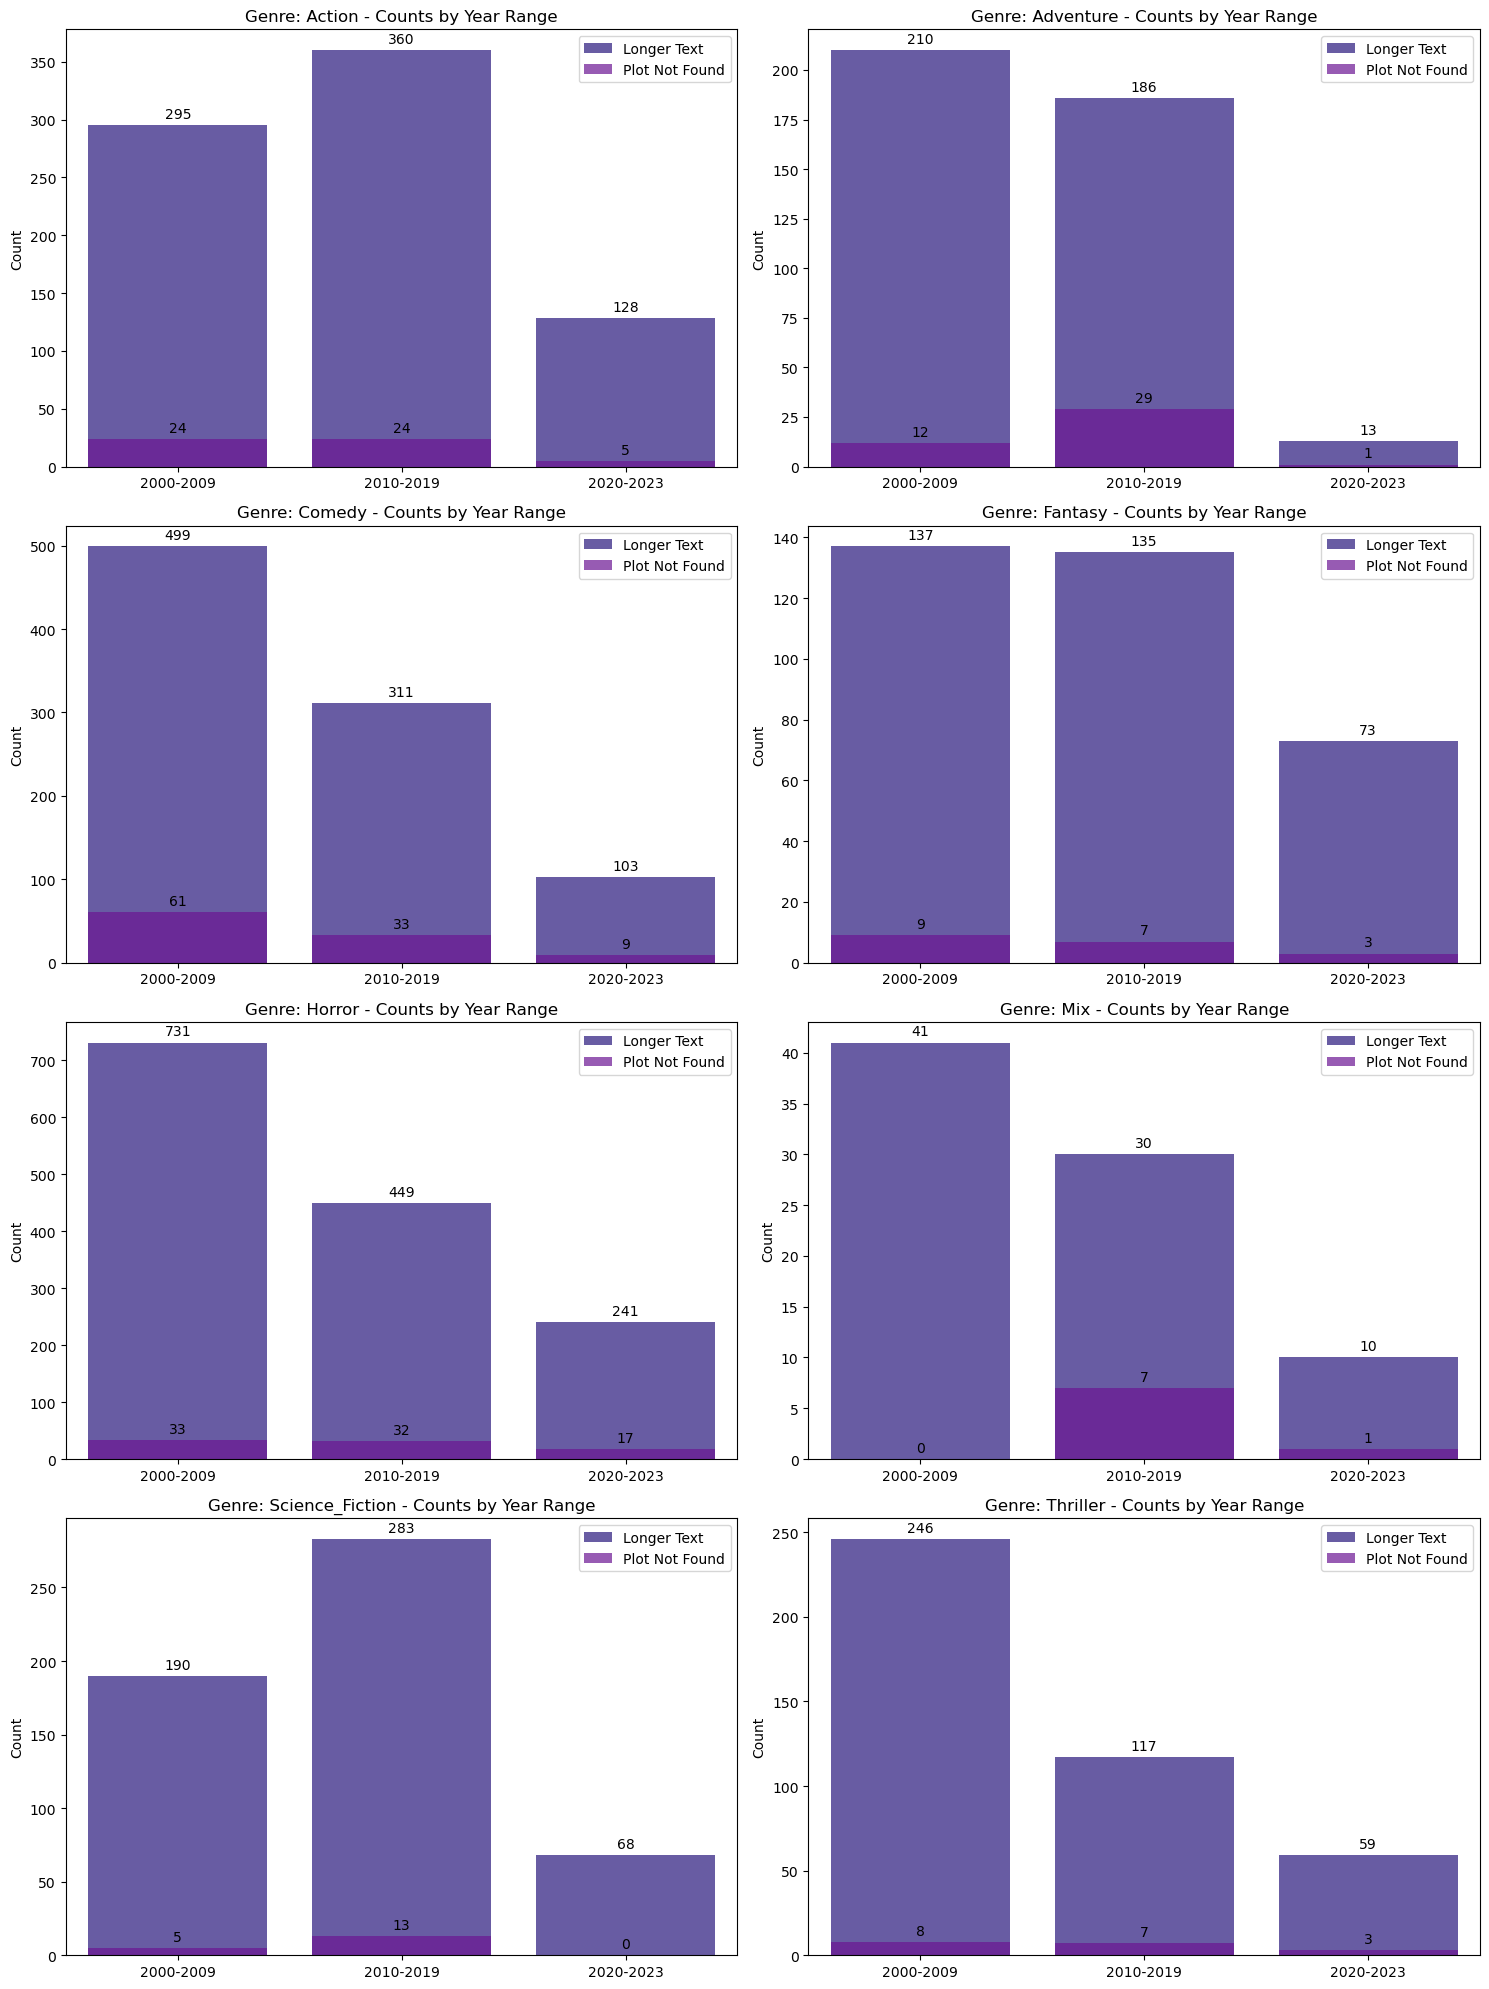

In [9]:
def aggregate_counts_by_range(year_counts, start, end, category):
    return sum(count[category] for year, count in year_counts.items() if start <= int(year) <= end)

def plot_histograms_seaborn(genre_counts):
    # Set up subplots for each genre in a 4x2 grid
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))

    # Define the year ranges
    ranges = [(2000, 2009), (2010, 2019), (2020, 2023)]

    # Define a color palette
    colors = sns.color_palette("husl", 2)  # Using the 'husl' color palette with 2 colors

    # Iterate over genres
    for i, (genre, year_counts) in enumerate(genre_counts.items()):
        # Aggregate counts for each range
        counts_longer_text = [aggregate_counts_by_range(year_counts, start, end, 'Longer text') for start, end in ranges]
        counts_plot_not_found = [aggregate_counts_by_range(year_counts, start, end, 'Plot not found') for start, end in ranges]

        # Plot bar plot using Seaborn
        row, col = divmod(i, 2)
        bar_width = 0.35
        opacity = 0.7

        # Adjust x-coordinates for the bars
        x = range(len(ranges))
        sns.barplot(x=[val - bar_width/2 for val in x], y=counts_longer_text, color=two_colors[0], alpha=opacity, ax=axs[row, col], label='Longer Text')
        sns.barplot(x=[val + bar_width/2 for val in x], y=counts_plot_not_found, color=two_colors[1], alpha=opacity, ax=axs[row, col], label='Plot Not Found')

        axs[row, col].set_xticks(x)
        axs[row, col].set_xticklabels([f'{start}-{end}' for start, end in ranges])
        axs[row, col].set_title(f'Genre: {genre} - Counts by Year Range')
        axs[row, col].set_ylabel('Count')
        axs[row, col].legend()

        # Add annotations above each bar
        for bar, count in zip(axs[row, col].patches, counts_longer_text + counts_plot_not_found):
            axs[row, col].annotate(count, 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Example usage with the previously obtained genre_counts
plot_histograms_seaborn(result)


### **Using the nltk Library**

Read Jasmins part. Make outline of what analysis the nltk could help with. Not implemented yet.

### **Word Clouds on Ratings**

In [104]:
# Extract the plots from files
def get_text_for_movie(movie_title):
    base_folder = '../Cinemartist-Networks-and-Interactions/'

    genres = os.listdir(base_folder)
    
    for genre in genres:
        genre_path = os.path.join(base_folder, genre)
        if os.path.isdir(genre_path):
            years = os.listdir(genre_path)
            for year in years:
                year_path = os.path.join(genre_path, year)
                if os.path.isdir(year_path):
                    # Use the cleaned movie title here
                    cleaned_title = clean_filename(movie_title)
                    file_path = os.path.join(year_path, f"{cleaned_title}.txt")
                    if os.path.exists(file_path):
                        with open(file_path, 'r', encoding='utf-8') as file:
                            return file.read()

    # If the movie title is not found, return an empty string
    return ""


In [105]:
# Sort the texts in ratings
high_rating_texts = []
moderate_rating_texts = []
low_rating_texts = []
for index, row in data_ratings.iterrows():
    movie_title = row['Title']
    text = get_text_for_movie(movie_title)

    if row['RatingLabel'] == 'High':
        high_rating_texts.append(text)
    elif row['RatingLabel'] == 'Moderate':
        moderate_rating_texts.append(text)
    else:
        low_rating_texts.append(text)

- Extract only words
- Lemmatizing words
- Lowercase of all words
- Some words are removed if they are a part of the stopwords in `nltk.corpus.stopwords.words('english')`

In [106]:
# Term Frequency (TF) 
def count_words_in_texts(texts):
    word_counter = collections.Counter()
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')

    for text in texts:
        text = text.lower()  # To lowercase
        words = re.findall(r'\b\w+\b', text)  # Extract words
        text_tokenized_lemma = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
        word_counter.update(text_tokenized_lemma)

    return word_counter

TF_high = count_words_in_texts(high_rating_texts)
TF_moderate = count_words_in_texts(moderate_rating_texts)
TF_low = count_words_in_texts(low_rating_texts)

- Calculate the TF-TF list for each rating category (see theory). This is three-way-wise Oh No

In [107]:
def calculate_tf_tr(tf1, tf2, tf3, c=20):
    tf_tr1 = {}
    tf_tr2 = {}
    tf_tr3 = {}
    
    # TF-TR for the first list
    for word, count in tf1.items():
        tf_tr1[word] = count / ((tf2.get(word, 0) + tf3.get(word, 0)) + c)
        
    # TF-TR for the second list
    for word, count in tf2.items():
        tf_tr2[word] = count / ((tf1.get(word, 0) + tf3.get(word, 0)) + c)
    
    # TF-TR for the third list
    for word, count in tf3.items():
        tf_tr3[word] = count / ((tf1.get(word, 0) + tf2.get(word, 0)) + c)
        
    return tf_tr1, tf_tr2, tf_tr3

# Calculating the TF-TR lists
TF_TR_high, TF_TR_moderate, TF_TR_low = calculate_tf_tr(TF_high, TF_moderate, TF_low)

In [108]:
# Converting the TF-TR lists to strings to be used in the WordCloud module
def convert_TF_TR_to_string(TF_TR):
    repeated_list = []
    for word, count in TF_TR.items():
        n = math.ceil(count)
        repeated_list.extend([word]*n)
    return ' '.join(repeated_list)

TF_TR_high_string = convert_TF_TR_to_string(TF_TR_high)
TF_TR_moderate_string = convert_TF_TR_to_string(TF_TR_moderate)
TF_TR_low_string = convert_TF_TR_to_string(TF_TR_low)

In [109]:
# Light variations in the word clouds
def random_lightness(base_lightness, min_variation, max_variation):
    variation = random.uniform(min_variation, max_variation)
    return max(0, min(100, base_lightness + variation))

def high_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 35
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(264, 96%, {lightness}%)"

def moderate_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 46
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(275, 96%, {lightness}%)"

def low_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 51
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(288, 96%, {lightness}%)"


In [110]:
# Define properties to plot the wordclouds
seed = 42

def plot_wordcloud(title, figure_number, text, color_func, rating_label):
    wordcloud = WordCloud(
        collocations=False,
        max_font_size=40,
        random_state=seed)

    # Generate the word cloud
    wordcloud.generate(text)

    # Recolor the word cloud using the custom color function
    colored_wordcloud = wordcloud.recolor(color_func=color_func, random_state=seed)

    # Plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(colored_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.suptitle(figure_number, fontsize=16, fontweight="bold")
    plt.title(title, fontweight="bold")
    plt.show()



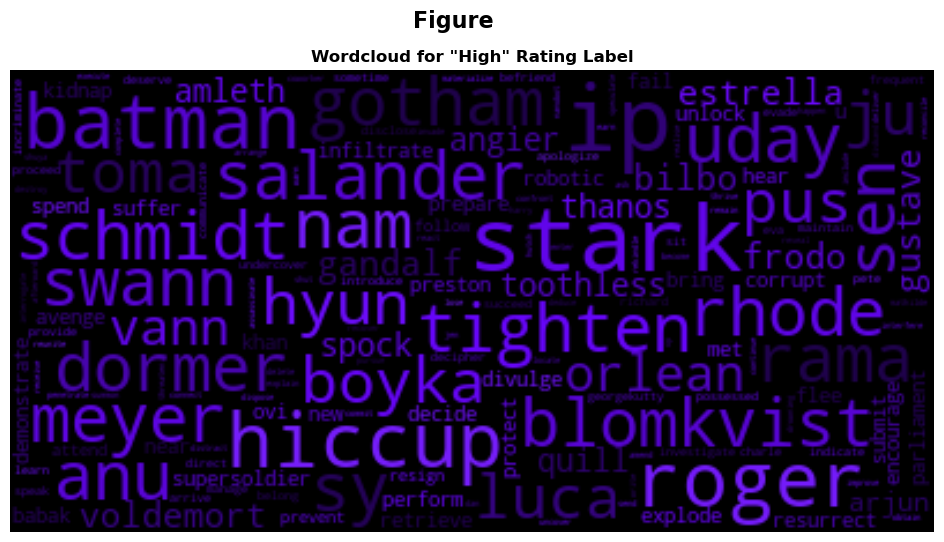

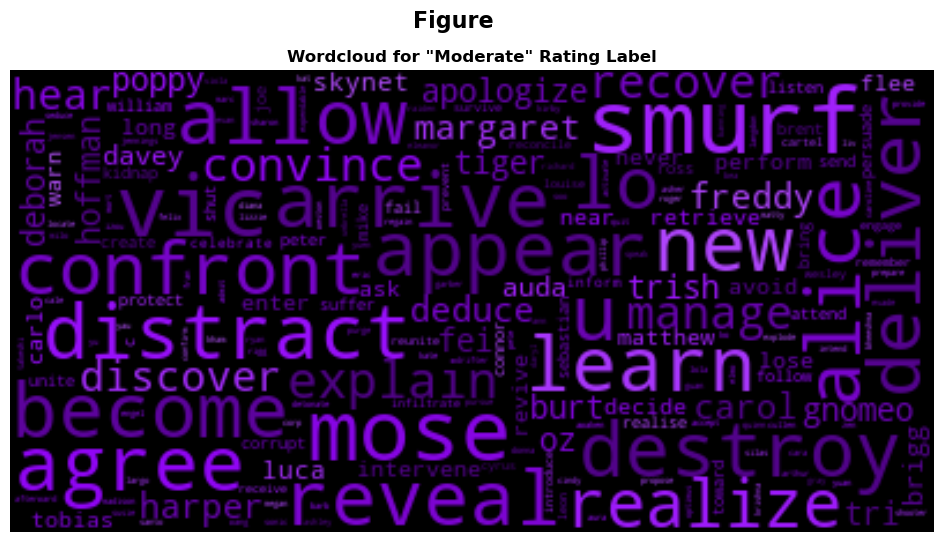

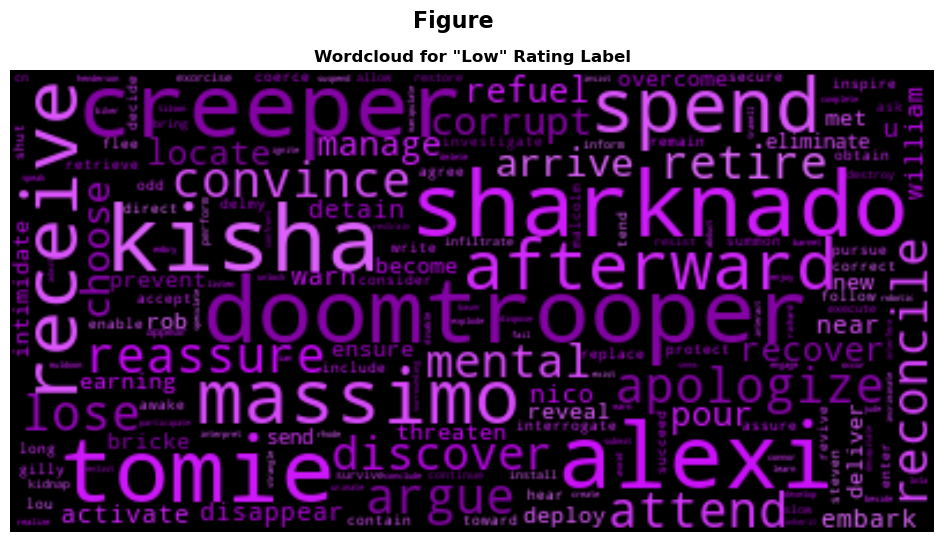

In [111]:
plot_wordcloud('Wordcloud for "High" Rating Label', "Figure ", TF_TR_high_string, high_color_func, 'High')
plot_wordcloud('Wordcloud for "Moderate" Rating Label', "Figure ", TF_TR_moderate_string, moderate_color_func, 'Moderate')
plot_wordcloud('Wordcloud for "Low" Rating Label', "Figure ", TF_TR_low_string, low_color_func, 'Low')

### **Word Clouds on Genres**

In [223]:
# Sort the texts in genres
action_rating_texts = []
adventure_rating_texts = []
comedy_rating_texts = []
fantasy_rating_texts = []
horror_rating_texts = []
mix_rating_texts = []
scifi_rating_texts = []
thriller_rating_texts = []

for index, row in data_ratings.iterrows():
    movie_title = row['Title']
    text = get_text_for_movie(movie_title)

    if row['Genre'] == 'Action':
        action_rating_texts.append(text)
    elif row['Genre'] == 'Adventure':
        adventure_rating_texts.append(text)
    elif row['Genre'] == 'Comedy':
        comedy_rating_texts.append(text)
    elif row['Genre'] == 'Fantasy':
        fantasy_rating_texts.append(text)
    elif row['Genre'] == 'Horror':
        horror_rating_texts.append(text)
    elif row['Genre'] == 'Mix':
        mix_rating_texts.append(text)
    elif row['Genre'] == 'Science Fiction':
        scifi_rating_texts.append(text)
    elif row['Genre'] == 'Thriller':
        thriller_rating_texts.append(text)

- Extract only words
- Lemmatizing words
- Lowercase of all words
- Some words are removed if they are a part of the stopwords in `nltk.corpus.stopwords.words('english')`

In [224]:
TF_action = count_words_in_texts(action_rating_texts)
TF_adventure = count_words_in_texts(adventure_rating_texts)
TF_comedy = count_words_in_texts(comedy_rating_texts)
TF_fantasy = count_words_in_texts(fantasy_rating_texts)
TF_horror = count_words_in_texts(horror_rating_texts)
TF_mix = count_words_in_texts(mix_rating_texts)
TF_scifi = count_words_in_texts(scifi_rating_texts)
TF_thriller = count_words_in_texts(thriller_rating_texts)

- Calculate the TF-TR list for each genre. !This is 8 dimensional!

In [225]:
# Multidimensional TF-TR list calculation
def calculate_tf_tr(*tfs, c=20):
    tf_tr = [{} for _ in range(len(tfs))]
    
    for i, tf1 in enumerate(tfs):
        for j, tf2 in enumerate(tfs):
            if i != j:
                for word, count in tf1.items():
                    tf_tr[i][word] = count / (sum(tf.get(word, 0) for k, tf in enumerate(tfs) if k != i) + c)
    
    return tf_tr

TF_TR_action, TF_TR_adventure, TF_TR_comedy, TF_TR_fantasy, TF_TR_horror, TF_TR_mix, TF_TR_scifi, TF_TR_thriller = calculate_tf_tr(TF_action, TF_adventure, TF_comedy, TF_fantasy, TF_horror, TF_mix, TF_scifi, TF_thriller)

In [226]:
# Convert the TF-TR lists to strings
TF_TR_action_string = convert_TF_TR_to_string(TF_TR_action)
TF_TR_adventure_string = convert_TF_TR_to_string(TF_TR_adventure)
TF_TR_comedy_string = convert_TF_TR_to_string(TF_TR_comedy)
TF_TR_fantasy_string = convert_TF_TR_to_string(TF_TR_fantasy)
TF_TR_horror_string = convert_TF_TR_to_string(TF_TR_horror)
TF_TR_mix_string = convert_TF_TR_to_string(TF_TR_mix)
TF_TR_scifi_string = convert_TF_TR_to_string(TF_TR_scifi)
TF_TR_thriller_string = convert_TF_TR_to_string(TF_TR_thriller)

In [227]:
# Light variations in the word clouds
def random_lightness(base_lightness, min_variation, max_variation):
    variation = random.uniform(min_variation, max_variation)
    return max(0, min(100, base_lightness + variation))

def horror_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 35
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(264, 96%, {lightness}%)"

def comedy_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 46
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(275, 96%, {lightness}%)"

def action_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 51
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(288, 96%, {lightness}%)"

def scifi_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 57
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(364, 59%, {lightness}%)"

def adventure_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 62
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(21, 87%, {lightness}%)"

def thriller_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 57
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(44, 98%, {lightness}%)"

def fantasy_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 60
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(51, 81%, {lightness}%)"

def mix_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    base_lightness = 58
    lightness = random_lightness(base_lightness, -20, 20)
    return f"hsl(49, 38%, {lightness}%)"

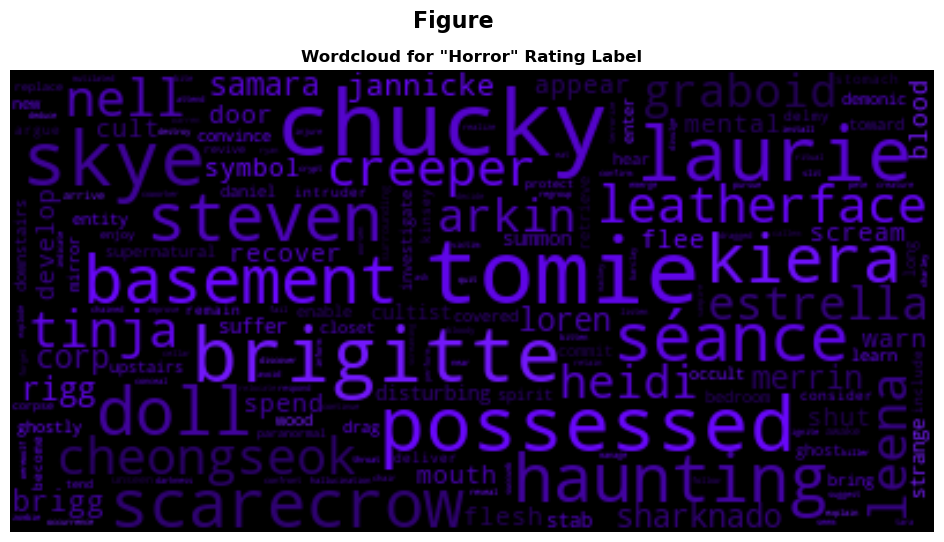

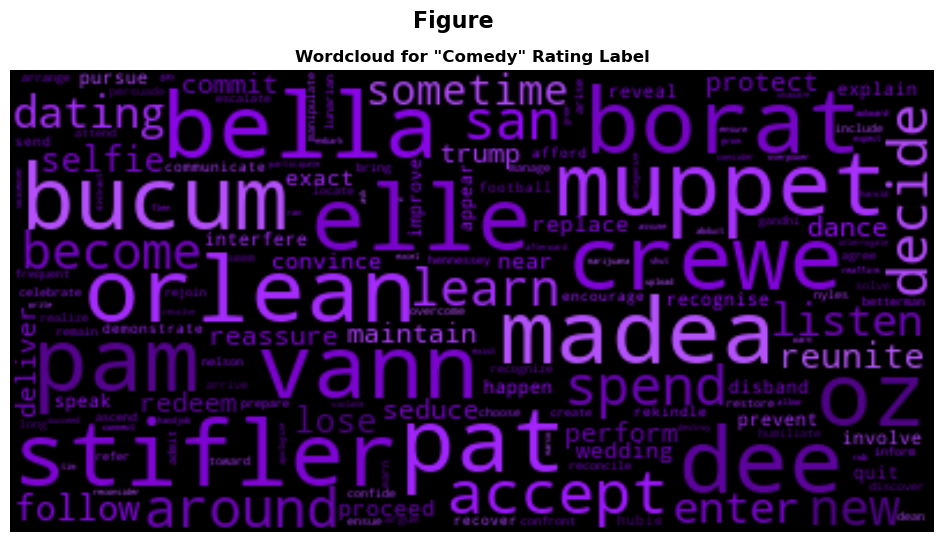

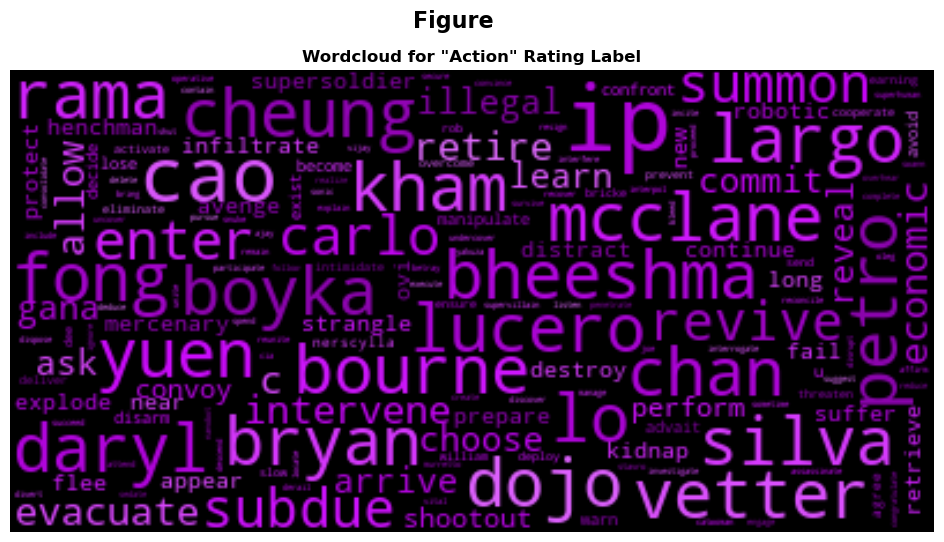

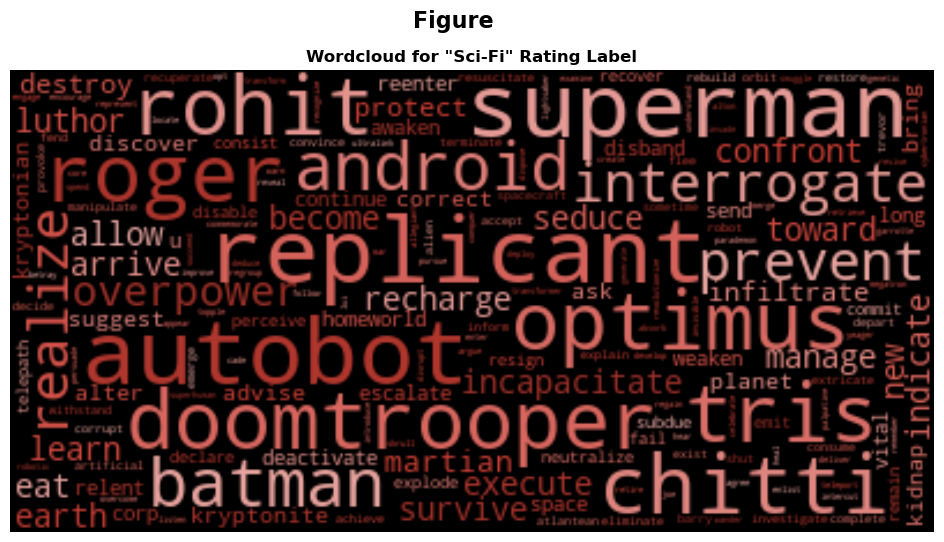

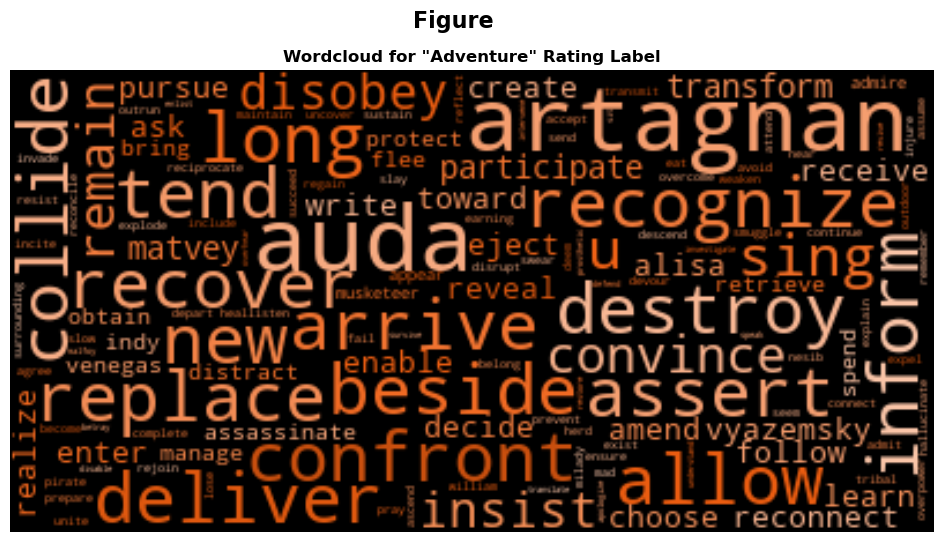

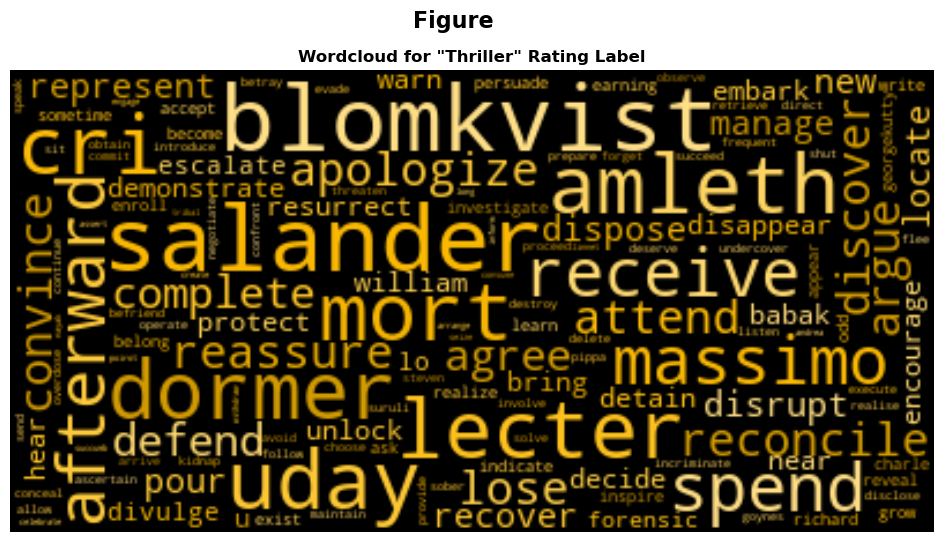

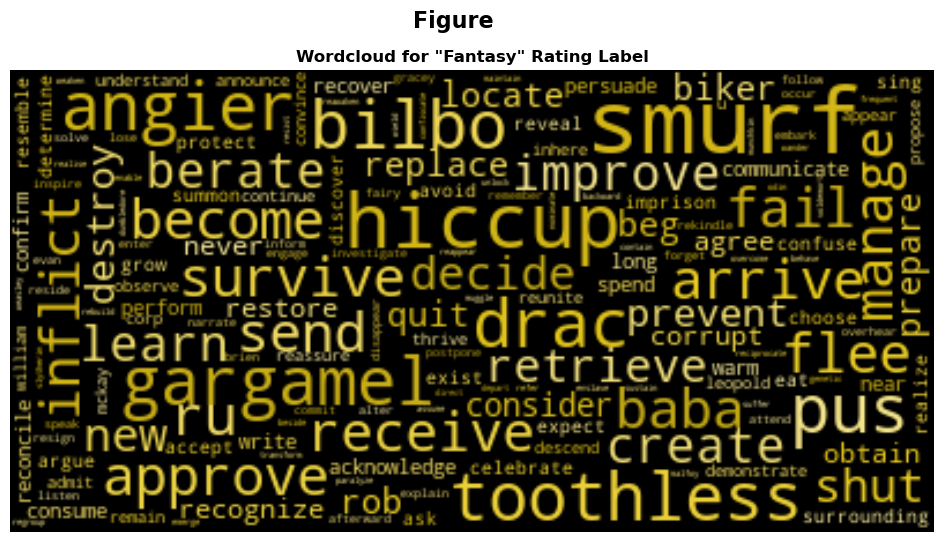

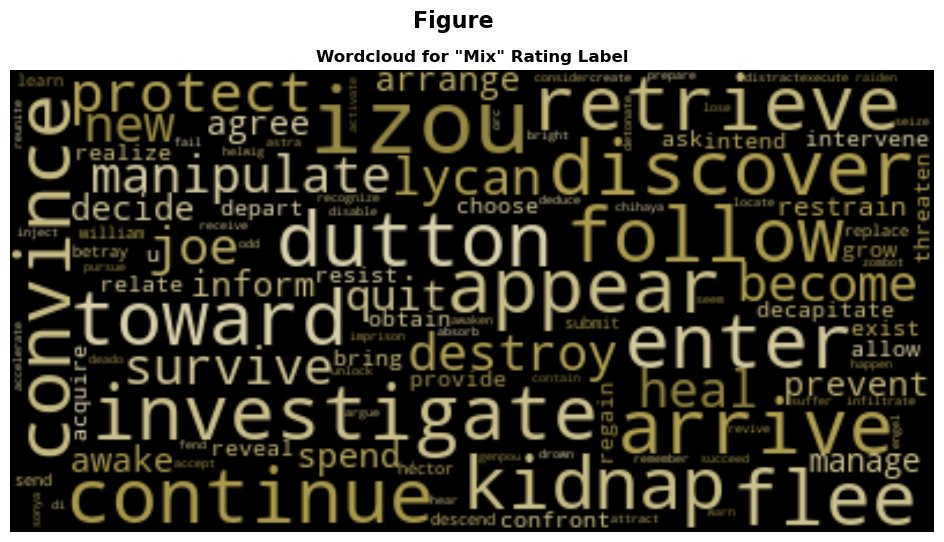

In [228]:
plot_wordcloud('Wordcloud for "Horror" Rating Label', "Figure ", TF_TR_horror_string, horror_color_func, 'Horror')
plot_wordcloud('Wordcloud for "Comedy" Rating Label', "Figure ", TF_TR_comedy_string, comedy_color_func, 'Comedy')
plot_wordcloud('Wordcloud for "Action" Rating Label', "Figure ", TF_TR_action_string, action_color_func, 'Action')
plot_wordcloud('Wordcloud for "Sci-Fi" Rating Label', "Figure ", TF_TR_scifi_string, scifi_color_func, 'Science Fiction')
plot_wordcloud('Wordcloud for "Adventure" Rating Label', "Figure ", TF_TR_adventure_string, adventure_color_func, 'Adventure')
plot_wordcloud('Wordcloud for "Thriller" Rating Label', "Figure ", TF_TR_thriller_string, thriller_color_func, 'Thriller')
plot_wordcloud('Wordcloud for "Fantasy" Rating Label', "Figure ", TF_TR_fantasy_string, fantasy_color_func, 'Fantasy')
plot_wordcloud('Wordcloud for "Mix" Rating Label', "Figure ", TF_TR_mix_string, mix_color_func, 'Mix')

### **Happiness Score / Sentiment Analysis**

The NLP analysis

#### **Using the VaderSentiment library**

A method aimed at classifying sentiment of social media text. The evaluated tokens includes emojies and slang words. There are 9000 words of token features rated by 10 independent people on a scale from “[–4] Extremely Negative” to “[4] Extremely Positive”, with allowance for “[0] Neutral (or Neither, N/A)”. The [dokumentation](https://vadersentiment.readthedocs.io/en/latest/pages/features_and_updates.html) and the libary is mentioned in this [*medium* artikel](https://medium.com/@urvisoni/vader-a-parsimonious-rule-based-model-for-sentiment-analysis-of-social-media-text-34380204b96f#:~:text=The%20Team%20of%20VADER%20calculating%20Sentiment%20rating%20from,with%20allowance%20for%20%E2%80%9C%20Neutral%20%28or%20Neither%2C%20N%2FA%29%E2%80%9D.). The token lexicon is in the [github](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt).

The compound score is here used as an indicator of the sentiment of a text. The compound value is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

In [124]:
# Create a copy of the original DataFrame
data_sentiments = data_ratings.copy()

# Add extra columns to the new DataFrame to store the sentiment scores
data_sentiments['Negative'] = ''
data_sentiments['Neutral'] = ''
data_sentiments['Positive'] = ''
data_sentiments['Compound'] = ''

In [137]:
# Using Vader sentiment
analyzer = SentimentIntensityAnalyzer()

for i, row in data_ratings.iterrows():
    movie_title = row['Title']
    # Pass the movie title through the cleaning function
    movie_plot = get_text_for_movie(clean_filename(movie_title))
    
    if not movie_plot:  # Check if the movie plot is not found
        # Set sentiment columns to NaN or any other appropriate value
        data_sentiments.at[i, 'Negative'] = float('nan')
        data_sentiments.at[i, 'Neutral'] = float('nan')
        data_sentiments.at[i, 'Positive'] = float('nan')
        data_sentiments.at[i, 'Compound'] = float('nan')
    else:
        sentiment = analyzer.polarity_scores(movie_plot)
        data_sentiments.at[i, 'Negative'] = sentiment['neg']
        data_sentiments.at[i, 'Neutral'] = sentiment['neu']
        data_sentiments.at[i, 'Positive'] = sentiment['pos']
        data_sentiments.at[i, 'Compound'] = sentiment['compound']


In [138]:
# Count the number of NaN values in the 'Compound' column
nan_count = data_sentiments['Compound'].isna().sum()

# Display the count
print(f"Number of movie rows with NaN values in the 'Compound' column: {nan_count}")

Number of movie rows with NaN values in the 'Compound' column: 363


In [139]:
data_sentiments.head(3)

Title                       Director  \
0   365 Days  barbara biaowas tomasz mandes   
1       7500               patrick vollrath   
2  Archenemy            adam egypt mortimer   

                                                Cast Country     Genre  Year  \
0  anna-maria sieklucka,michele morrone, bronisaw...  europe  Thriller  2020   
1                   joseph gordon-levitt,aylin tezel     mix    Action  2020   
2  joe manganiello,skylan brooks, zolee griggs,pa...     mix    Action  2020   

               Hyperref Decade  Rating RatingLabel Negative Neutral Positive  \
0  365_Days_(2020_film)  20-29     3.3         Low    0.095   0.808    0.097   
1           7500_(film)  20-29     6.3    Moderate    0.171   0.776    0.053   
2      Archenemy_(film)  20-29     5.0         Low    0.192   0.808      0.0   

  Compound  
0   0.8834  
1  -0.9987  
2  -0.8074

In [140]:
# Display the data types of the newly added columns
print("Data Types of Newly Added Columns:")
print(data_sentiments[['Negative', 'Neutral', 'Positive', 'Compound']].dtypes)


Data Types of Newly Added Columns:
Negative    object
Neutral     object
Positive    object
Compound    object
dtype: object


In [141]:
# Convert the newly added columns to float
data_sentiments[['Negative', 'Neutral', 'Positive', 'Compound']] = data_sentiments[['Negative', 'Neutral', 'Positive', 'Compound']].astype('float')

In [143]:
# Add a new column 'VaderSentiment' for the sentiment class
data_sentiments['VaderSentiment'] = ''

for i, row in data_sentiments.iterrows():
    compound_score = row['Compound']
    
    # Classify based on the compound score
    if compound_score >= 0.5:
        data_sentiments.at[i, 'VaderSentiment'] = 'Positive'
    elif compound_score <= -0.5:
        data_sentiments.at[i, 'VaderSentiment'] = 'Negative'
    else:
        data_sentiments.at[i, 'VaderSentiment'] = 'Neutral'


In [144]:
data_sentiments.head(3) # Now the Vader Sentiment is included in the dataframe

Title                       Director  \
0   365 Days  barbara biaowas tomasz mandes   
1       7500               patrick vollrath   
2  Archenemy            adam egypt mortimer   

                                                Cast Country     Genre  Year  \
0  anna-maria sieklucka,michele morrone, bronisaw...  europe  Thriller  2020   
1                   joseph gordon-levitt,aylin tezel     mix    Action  2020   
2  joe manganiello,skylan brooks, zolee griggs,pa...     mix    Action  2020   

               Hyperref Decade  Rating RatingLabel  Negative  Neutral  \
0  365_Days_(2020_film)  20-29     3.3         Low     0.095    0.808   
1           7500_(film)  20-29     6.3    Moderate     0.171    0.776   
2      Archenemy_(film)  20-29     5.0         Low     0.192    0.808   

   Positive  Compound VaderSentiment  
0     0.097    0.8834       Positive  
1     0.053   -0.9987       Negative  
2     0.000   -0.8074       Negative

In [169]:
# Sentiment Distributions
# Remove rows with NaN values in the 'Compound' column
data_sentiments_with_plots = data_sentiments.dropna(subset=['Compound'])

# Calculate counts for each sentiment category for movies with plots
count_neg_movie = data_sentiments_with_plots[data_sentiments_with_plots['VaderSentiment'] == 'Negative'].shape[0]
count_neu_movie = data_sentiments_with_plots[data_sentiments_with_plots['VaderSentiment'] == 'Neutral'].shape[0]
count_pos_movie = data_sentiments_with_plots[data_sentiments_with_plots['VaderSentiment'] == 'Positive'].shape[0]

# Calculate the total number of movies with plots
total_movies_with_plots = len(data_sentiments_with_plots)

print("Total number of movies with plots:", total_movies_with_plots)
print("Number of negative movies:", count_neg_movie)
print("Number of neutral movies:", count_neu_movie)
print("Number of positive movies:", count_pos_movie)


Total number of movies with plots: 4884
Number of negative movies: 3471
Number of neutral movies: 654
Number of positive movies: 759


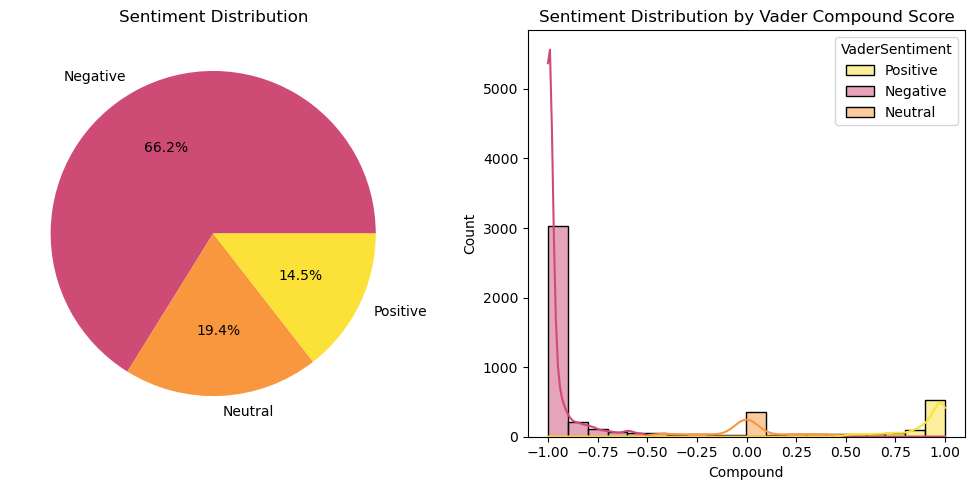

In [168]:
# Create a pie plot
labels = 'Negative', 'Neutral', 'Positive'
values = [count_neg_movie, count_neu_movie, count_pos_movie]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=three_sentiment_colors)
plt.title('Sentiment Distribution')

# Create histograms for each sentiment category
plt.subplot(1, 2, 2)
sns.histplot(data_sentiments, x='Compound', hue='VaderSentiment', bins=20,
             palette={'Positive': three_sentiment_colors[2], 'Neutral': three_sentiment_colors[1], 'Negative': three_sentiment_colors[0]}, kde=True)
plt.title('Sentiment Distribution by Vader Compound Score')

plt.tight_layout()
plt.show()

A very large portion of the movies have a negative compound score. This could be because of the genres that are currently analysised. Or that people like to watch movies that are classified as negative witch action and drama. 

Again this could be because of the chosen genres in this analysis. Please note, that this is not a finite analysis of the whole movie industry.

##### **Analysis of sentiment pr Genre and sentiment pr RatingLabel**

In [254]:
# Sentiment pr Genre
np.random.seed(42)

# Select 300 plots from each genre except "Mix"
selected_df = pd.concat([genre_plots.sample(min(300, len(genre_plots)), random_state=42)
                        for genre, genre_plots in data_sentiments.dropna(subset=['Compound']).groupby('Genre')
                        if genre != 'Mix'])


In [255]:
# Count:
genre_counts = selected_df['Genre'].value_counts()

print("Genre Counts:")
print(genre_counts)


Genre Counts:
Action             300
Adventure          300
Comedy             300
Fantasy            300
Horror             300
Science Fiction    300
Thriller           300
Name: Genre, dtype: int64


In [256]:
# Calculate the percentage of negative, neutral, and positive movies for each genre
genre_counts = selected_df.groupby(['Genre', 'VaderSentiment']).size().unstack().fillna(0)
genre_percentage = genre_counts.div(genre_counts.sum(axis=1), axis=0) * 100

# Reshape the DataFrame for plotting
long_df = genre_percentage.reset_index().melt(id_vars='Genre', var_name='Sentiment', value_name='Percentage')

In [257]:
# Set the order of how to plot the genres
genre_order = ['Horror', 'Comedy', 'Action', 'Science Fiction', 'Adventure', 'Thriller', 'Fantasy']

# Plotting using the sentiment colors
three_sentiment_colors_hex = ['#ce4a75', '#f8963f', '#fae038']

# Plotting using the sentiment colors
fig = px.bar(long_df, x="Genre", y="Percentage", color="Sentiment",
             title="Sentiment Distribution per Genre",
             labels={'Percentage': '%', 'Sentiment': 'Sentiment'},
             color_discrete_map={'Positive': three_sentiment_colors_hex[2],
                                 'Neutral': three_sentiment_colors_hex[1],
                                 'Negative': three_sentiment_colors_hex[0]},
             category_orders={"Genre": genre_order})

# Set bar mode to 'stack'
fig.update_layout(barmode='stack', title_x=0.5, legend=dict(x=1.0, y=0.5))
config = {'displayModeBar': False}

fig.show(config=config)


From the plot above, the Comedy and the fantasy genres seems to have a larger distribution of the positive and neutral movie plots. The horror genre and the thriller genre on the other hand have very few positive plots.

The 10 most Positive and the 10 most negative movies based on the Vader Sentiment:

In [263]:
# The 10 most positive movies
data_sentiments[['Title', 'Genre', 'Rating', 'RatingLabel', 'Compound']].nlargest(10, 'Compound')

Title      Genre  Rating RatingLabel  Compound
1141            Magic Camp     Comedy     6.3    Moderate    0.9994
1440      I Give It a Year     Comedy     5.7    Moderate    0.9990
1261           Just Wright     Comedy     5.9    Moderate    0.9989
1209                  Luck    Fantasy     6.4    Moderate    0.9988
2053            Date Movie     Comedy     2.8         Low    0.9988
4206               Shrek 2    Fantasy     7.3        High    0.9988
2390              Stranded  Adventure     7.2        High    0.9986
1543                Trolls    Fantasy     5.9    Moderate    0.9983
1750  Bend It Like Beckham     Comedy     6.7    Moderate    0.9982
1136                  Emma     Comedy     6.7    Moderate    0.9981

The movie like "Magic Camp" includes words like "succesful", "famous", "Hearts", "embraces" and "winner". Although the text also includes words like "death" and "grudge" the overweight is on the more positive sounding words. The movie "Shrek 2" includes words like "newlyweds", "marry" and a lot of repetition of "happily ever after". 

In [261]:
# The 10 most negative movies
data_sentiments[['Title', 'Genre', 'Rating', 'RatingLabel', 'Compound']].nsmallest(10, 'Compound')

Title      Genre  Rating RatingLabel  Compound
434   The Baader Meinhof Complex   Thriller     7.3        High   -0.9998
953                      In Hell     Action     6.1    Moderate   -0.9998
2513                  Barbarossa  Adventure     4.4         Low   -0.9998
3287                   Route 666     Horror     4.4         Low   -0.9998
3417              Shallow Ground     Horror     4.9         Low   -0.9998
4748                         Cut     Comedy     6.1    Moderate   -0.9998
886               Romeo Must Die     Action     6.1    Moderate   -0.9997
1538             Kung Fu Panda 3     Comedy     7.1        High   -0.9997
1556               Tragedy Girls     Horror     6.0    Moderate   -0.9997
2905           The ABCs of Death     Horror     4.7         Low   -0.9997

The movies here such as "The Baader Meinhof Complex" includes words like "angered", "shot", "fatally" and "death" throughtout the whole text. Likewise with the movie "Kung Fu Panda 3" includes words like "defeated", "fights", "stolen" and "disheartened". This leads to the movie plots being classified with a low sentiment score near (-1).

In [260]:
# Neutral movies (compound scores [-0.5 , 0.5])
neutral_movies = data_sentiments[(data_sentiments['Compound'] >= -0.1) & (data_sentiments['Compound'] <= 0.1)]
neutral_movies[['Title', 'Genre', 'Rating', 'RatingLabel', 'Compound']].head(3)

Title     Genre  Rating RatingLabel  Compound
23  The Retreat  Thriller     4.9         Low       0.0
29      Akshara  Thriller     5.1         Low       0.0
38     Lockdown  Thriller     6.2    Moderate       0.0

Now, we also want to look at the distribution of sentiment by Rating Label. So far, it seems there is no initial connection between RatingLabel and the sentiment.

In [249]:
# Select 1000 plots from each RatingLabel
selected_df_ratings = pd.concat([rating_plots.sample(min(1000, len(rating_plots)), random_state=42)
                         for rating, rating_plots in data_sentiments.dropna(subset=['Compound']).groupby('RatingLabel')])

In [250]:
# Count:
rating_counts = selected_df_ratings['RatingLabel'].value_counts()

print("RatingLabel Counts:")
print(rating_counts)

RatingLabel Counts:
High        1000
Low         1000
Moderate    1000
Name: RatingLabel, dtype: int64


In [252]:
# Calculate the percentage of negative, neutral, and positive movies for each RatingLabel
rating_counts = selected_df_ratings.groupby(['RatingLabel', 'VaderSentiment']).size().unstack().fillna(0)
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Reshape the DataFrame for plotting
long_df = rating_percentage.reset_index().melt(id_vars='RatingLabel', var_name='Sentiment', value_name='Percentage')

# Set the order of how to plot the RatingLabels
rating_order = ['High', 'Moderate', 'Low']

# Plotting using the sentiment colors
fig = px.bar(long_df, x="RatingLabel", y="Percentage", color="Sentiment",
             title="Sentiment Distribution per RatingLabel",
             labels={'Percentage': '%', 'Sentiment': 'Sentiment'},
             color_discrete_map={'Positive': three_sentiment_colors_hex[2],
                                 'Neutral': three_sentiment_colors_hex[1],
                                 'Negative': three_sentiment_colors_hex[0]},
             category_orders={"RatingLabel": rating_order})

# Set bar mode to 'stack'
fig.update_layout(barmode='stack', title_x=0.5, legend=dict(x=1.0, y=0.5))
config = {'displayModeBar': False}

fig.show(config=config)


This analysis on the RatingLabel by sentiment does not show a clear connection between the rating given to a movie and the sentiment of its text. This makes sense because a well-rated movie doesn't necessarily have a predetermined positive or negative sentiment.

For example, a thriller like "The Baader Meinhof Complex" can have a very negative-sounding plot (compound score of -0.9998) and at the same time receive a high rating (7.3). On the other hand, a fantasy movie like "Shrek 2" can get the same high rating (7.3) can have a plot with a positive sentiment (compound score of 0.9988). This means that extremely negative (-1) or positive (1) sentiment scores can both be associated with movies receiving the same rating.

A deeper look into the average compound scores of the rating label categories:

In [290]:
# Printing the mean compound scores of different Rating categories
high_rating_df = data_sentiments[data_sentiments['RatingLabel'] == 'High']
mod_rating_df = data_sentiments[data_sentiments['RatingLabel'] == 'Moderate']
low_rating_df = data_sentiments[data_sentiments['RatingLabel'] == 'Low']

print(f"Rating 'High', average compound score : {high_rating_df['Compound'].mean()}")
print(f"Rating 'High', average compound score : {mod_rating_df['Compound'].mean()}")
print(f"Rating 'High', average compound score : {low_rating_df['Compound'].mean()}")
print(f"Average compound score : {data_sentiments['Compound'].mean()}")

Rating 'High', average compound score : -0.5407151820294341
Rating 'High', average compound score : -0.527253099091984
Rating 'High', average compound score : -0.5753037735849057
Average compound score : -0.5412402538902531


##### **Permutation Test: Does Compound Value Relate to RatingLabel?**

Now, it is essential to evaluate whether there is a relation between the sentiment of a movie plot, here the compound value, versus the Rating label. I.e. we aim to test whether the mean values of the Rating categories are significantly different on a chosen 5% confidence bound. The rating labels are still divided into the categories "High", "Moderate" and "Low". So far the sentiment analysis has not indicated that there is any relation. That we also see because the mean values of the compounds are very similar as shown above.

First, the test statistic is based on the difference in means between rating label with greatest compound mean ("Moderate") and the rating label with smallest compound mean ("Low"). Afterwards, there is done a shuffling of the Compound value so that we keep the distribution of Rating labels and assign a random Compound scores. The p-value is calculated and tested against a significance level of 0.05.

In [295]:
# Function to calculate test statistic
def test_statistic(data_sentiments):
    # Replace with your specific test statistic calculation
    return data_sentiments.groupby('RatingLabel')['Compound'].mean().max() - data_sentiments.groupby('RatingLabel')['Compound'].mean().min()

observed_statistic = test_statistic(data_sentiments)

# Permutation test
n_permutations = 10000
count = 0
permuted_statistics = []

for _ in range(n_permutations):
    # Shuffle the sentiment scores
    shuffled_sentiment = np.random.permutation(data_sentiments['Compound'])
    
    # Assign shuffled scores back to dataframe
    shuffled_df = data_sentiments.copy()
    shuffled_df['Compound'] = shuffled_sentiment
    
    # Recalculate test statistic
    permuted_statistic = test_statistic(shuffled_df)
    
    # Compare with observed statistic
    if permuted_statistic >= observed_statistic:
        count += 1

    # Store permuted statistic for histogram
    permuted_statistics.append(permuted_statistic)

# Calculate p-value
p_value = count / n_permutations

print(f"Observed statistic: {observed_statistic}")
if p_value <= 0.05:
    print(f"The highest rating label category has a significantly different mean compound score than the lowest rating label category against a random shuffling of the compound values.")
else:
    print(f"The p-value ({p_value}) indicate no significant difference in sentiment between the rating label category with the greatest vs. with the lowest average compound score against a random shuffling of the compound values.")

Observed statistic: 0.04805067449292
The p-value (0.1671) indicate no significant difference in sentiment between the rating label category with the greatest vs. with the lowest average compound score against a random shuffling of the compound values.


By the permutation test there is no significant difference in sentiment between the rating label category ("Moderate") with the greatest average compound score and the rating label category ("Low") with the lowest average compound score against a random shuffling of the compound values. The p-value calculated with the 10000-fold permutation test is 0.1631 which is greater than the significance level of 0.05, i.e. there is no significance shown. Since there is no significant difference between the greatest and the lowest rating label category of compound sentiment value, there is no difference between the three RatingLabel categories "High", "Moderate" and "Low". This means we cannot say there is a significant relation between rating label and the compound score (sentiment). 

We explore the distribution of the calculated permutations. The plot is a "cutted" normaldistribution due to that we use the test statistic that subtracts the minimum compound value from the maximum compound value. This value cannot be below zero.

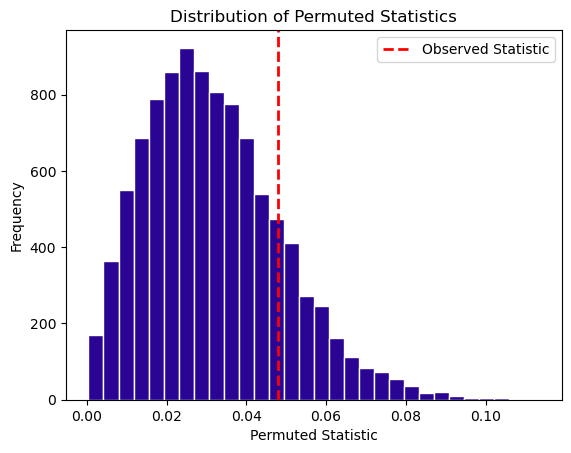

In [297]:
# Plot histogram
plt.hist(permuted_statistics, bins=30, edgecolor='white', color=colorpalette[1])
plt.axvline(x=observed_statistic, color=colorpalette[20], linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.title('Distribution of Permuted Statistics')
plt.xlabel('Permuted Statistic')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The Observed statistic is located within the largest distribution of the plot, this also leads that it cannot be conluded from the permutation that the there is a significant difference.

This result makes sense to us, in conclusion, the permutation test results, with a non-significant p-value of 0.1631, indicate that there is no discernible relationship between the sentiment of a movie's plot and its assigned rating label ("High," "Moderate," or "Low"). This aligns with the understanding that diverse movie plots can receive similar ratings, as exemplified by contrasting films such as the thriller "The Baader Meinhof Complex" and the fantasy "Shrek 2," both rated at 7.3. The lack of statistical significance suggests that variations in sentiment across different rating labels may occur randomly rather than being indicative of a meaningful connection. Therefore, the analysis does not provide evidence supporting a consistent influence of plot sentiment on movie ratings.

##### To check Vader sentiment for a single movie

In [123]:
# Single check of actual title of the movie you want to analyze
movie_title_to_analyze = 'Garfield: A Tail of Two Kitties'

# Using Vader sentiment
analyzer = SentimentIntensityAnalyzer()

# Get the plot text for the specified movie title
movie_plot = get_text_for_movie(movie_title_to_analyze)
print(movie_plot)

# Check if the movie plot is not empty
if movie_plot:
    # Perform sentiment analysis
    sentiment = analyzer.polarity_scores(movie_plot)

    # Display the sentiment scores
    print(f"Sentiment scores for '{movie_title_to_analyze}':")
    print(f"Negative: {sentiment['neg']}")
    print(f"Neutral: {sentiment['neu']}")
    print(f"Positive: {sentiment['pos']}")
    print(f"Compound: {sentiment['compound']}")
else:
    print(f"Plot not found for '{movie_title_to_analyze}'.")

Two years after the events of the first film, Jon Arbuckle plans to propose to his girlfriend, veterinarian Dr. Elizabeth "Liz" Wilson, who is going on a business trip to London. Jon follows Liz to the United Kingdom as a surprise; after escaping from a kennel, Jon's two pets, Garfield and Odie, sneak into Jon's luggage and join him on the trip. Garfield and Odie break out of the hotel room due to boredom, and subsequently get lost in the streets of London.

Meanwhile, at Carlyle Castle in the English countryside, the late Lady Eleanor Carlyle's will is read by the solicitors, Mr. Hobbs, Mr. Greene and Mrs. Whitney. She bequeaths Carlyle Castle to Prince XII, her beloved cat who lives a strong life of luxury, and bears a strong resemblance to Garfield. This enrages the Lady's greedy nephew, Lord Manfred Dargis, who will now only inherit the grand estate once Prince passes away. Lord Dargis traps Prince in a picnic basket and throws him into the river. Jon finds Prince climbing out of a

#### **Using the Happiness Scores sheet LabMT wordlist**

The method thaught in class. Here the sentiment of different words are decided from the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). There are 10,222 words in the data set and their average happiness evaluations according to users on Mechanical Turk, and other information as described below. The average happiness is evaluated on 50 user evaluations. The tokens are rated on a scale from [1, 8.5] on average happiness of a given word. The average happiness is used in this analysis.

In [298]:
# Add extra column to the DataFrame to store the average_happiness sentiment scores
data_sentiments['AverageHappiness'] = ''

In [300]:
# Import the happiness LabMT scores
happiness = {}

with open('Data_Set_S1.txt') as f:
    for w, h in re.findall(r'([a-z]+)\t\d+\t([\d.]+)', f.read()):
        happiness[w] = float(h)

In [315]:
# Function that calculates sentiment given a list of tokens (lower case)
# "text" contains the token list
def calculate_sentiment(text, sentiment_list): 
    unique_words = list(set(text))
    f_k = 0
    t_k_fk = 0
    for token in unique_words: 
        if token in sentiment_list: 
            v_token = sentiment_list[token]
            f_token = text.count(token)
            f_k += f_token
            t_k_fk += v_token*f_token
    text_sentiment = t_k_fk / f_k if f_k > 0 else None
    return text_sentiment

In [327]:
# Append the sentiment score for each movie
none_count = 0
for i, row in data_ratings.iterrows():
    movie_title = row['Title']
    
    # Pass the movie title through the cleaning function and get the text plot
    movie_plot = get_text_for_movie(clean_filename(movie_title))

    if not movie_plot:  # Check if movie plot is found
        none_count += 1
        happiness_score = None
    else:
        text = movie_plot.lower()  # Lowercase
        words = word_tokenize(text) # Tokenize

        # Calculate sentiment via Dataset S1
        happiness_score = calculate_sentiment(words, happiness)

    # Find the corresponding row in data_sentiments and update "AverageHappiness"
    data_sentiments.loc[data_sentiments['Title'] == movie_title, 'AverageHappiness'] = happiness_score


In [373]:
# Display the data types of the newly added columns
print("Data Types of Newly Added Columns:")
print(data_sentiments[['AverageHappiness']].dtypes)

Data Types of Newly Added Columns:
AverageHappiness    object
dtype: object


In [374]:
# Convert the newly added columns to float
data_sentiments[['AverageHappiness']] = data_sentiments[['AverageHappiness']].astype('float')

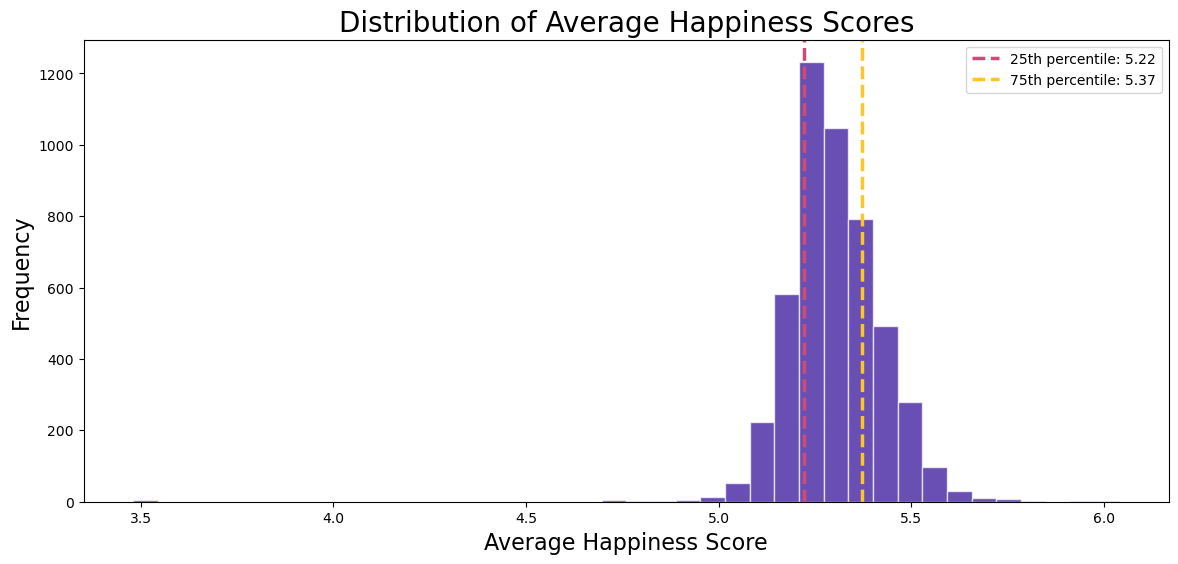

In [331]:
# Filter out rows with None in AverageHappiness
filtered_data = data_sentiments[data_sentiments['AverageHappiness'].notnull()]

# Plot the histogram of distribution of average happiness score
plt.figure(figsize=(14, 6))
plt.hist(filtered_data['AverageHappiness'], bins=40, edgecolor='white', color=colorpalette[1])
plt.xlabel('Average Happiness Score', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Average Happiness Scores', fontsize=20)

# Add lines for 25% and 75% quantiles
quantiles = filtered_data['AverageHappiness'].quantile([0.25, 0.75])
plt.axvline(quantiles[0.25], color=colorpalette[20], linestyle='dashed', linewidth=2.5, label=f"25th percentile: {quantiles[0.25]:.2f}")
plt.axvline(quantiles[0.75], color=colorpalette[35], linestyle='dashed', linewidth=2.5, label=f"75th percentile: {quantiles[0.75]:.2f}")
plt.legend()
plt.show()


It is noted that there are some movies with very low average happiness score. These are investigated.

In [332]:
# Filter movies with AverageHappiness below 4
low_happiness_movies = data_sentiments[data_sentiments['AverageHappiness'] < 4]

print("Movies with AverageHappiness below 4:")
for index, row in low_happiness_movies.iterrows():
    print(row['Title'])


Movies with AverageHappiness below 4:
Tokyo Raiders
Curveball
Choking Hazard
Nobody Sleeps in the Woods Tonight Part 2
Bitch Ass
Hellblazers


All these movies above have no written plot on their corresponding Wikipedia pages. However, there are boxes indicating that it is possible to write a plot. This have been scrapped as the plot. Now they are removed. 

In [338]:
# Drop movies with AverageHappiness below 4
low_happiness_indices = data_sentiments[data_sentiments['AverageHappiness'] < 4].index
data_sentiments = data_sentiments.drop(low_happiness_indices)

Remove all movies with None in AverageHappiness value

In [348]:
# Create a new dataframe without rows with None values in AverageHappiness
data_sentiments_only_plots = data_sentiments[data_sentiments['AverageHappiness'].notnull()]

# Count the number of rows with None values
count_none_values = data_sentiments.shape[0] - data_sentiments_only_plots.shape[0]

# Print the count
print(f"Number of rows with None values in AverageHappiness: {count_none_values}")


Number of rows with None values in AverageHappiness: 365


Based on the 25th and 75th quantiles we map into Positve, Negative or Neutral Happiness label.

In [ ]:
# Add extra column to the DataFrame to store the happiness sentiment label
data_sentiments_only_plots['HappinessLabel'] = ''

In [353]:
# Calculate the 25th and 75th quantiles
quantiles = data_sentiments_only_plots['AverageHappiness'].quantile([0.25, 0.75])
quantile_25 = quantiles[0.25]
quantile_75 = quantiles[0.75]

# Define a function to map AverageHappiness to labels
def map_to_happiness_label(average_happiness):
    if average_happiness < quantile_25:
        return 'Negative'
    elif average_happiness > quantile_75:
        return 'Positive'
    else:
        return 'Neutral'

# Apply the function to create the 'HappinessLabel' column
data_sentiments_only_plots['HappinessLabel'] = data_sentiments_only_plots['AverageHappiness'].apply(map_to_happiness_label)


C:\Users\johan\AppData\Local\Temp\ipykernel_9868\2229885340.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [356]:
# Calculate the 25th and 75th quantiles for the filtered dataframe
quantiles = data_sentiments_only_plots['AverageHappiness'].quantile([0.25, 0.75])
quantile_25 = quantiles[0.25]
quantile_75 = quantiles[0.75]

# Define a function to map AverageHappiness to labels
def map_to_happiness_label(average_happiness):
    if average_happiness < quantile_25:
        return 'Negative'
    elif average_happiness > quantile_75:
        return 'Positive'
    else:
        return 'Neutral'

# Apply the function to create the 'HappinessLabel' column using .loc
data_sentiments_only_plots.loc[:, 'HappinessLabel'] = data_sentiments_only_plots['AverageHappiness'].apply(map_to_happiness_label)

C:\Users\johan\AppData\Local\Temp\ipykernel_9868\2803979416.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [357]:
data_sentiments_only_plots.head(3)

Title                       Director  \
0   365 Days  barbara biaowas tomasz mandes   
1       7500               patrick vollrath   
2  Archenemy            adam egypt mortimer   

                                                Cast Country     Genre  Year  \
0  anna-maria sieklucka,michele morrone, bronisaw...  europe  Thriller  2020   
1                   joseph gordon-levitt,aylin tezel     mix    Action  2020   
2  joe manganiello,skylan brooks, zolee griggs,pa...     mix    Action  2020   

               Hyperref Decade  Rating RatingLabel  Negative  Neutral  \
0  365_Days_(2020_film)  20-29     3.3         Low     0.095    0.808   
1           7500_(film)  20-29     6.3    Moderate     0.171    0.776   
2      Archenemy_(film)  20-29     5.0         Low     0.192    0.808   

   Positive  Compound VaderSentiment AverageHappiness HappinessLabel  
0     0.097    0.8834       Positive         5.362887        Neutral  
1     0.053   -0.9987       Negative         5.181582       Negative  
2     0.000   -0.8074       Negative         4.983529       Negative

In [358]:
# Sentiment Distributions
# Calculate counts for each sentiment category for movies with plots
count_neg_movie = data_sentiments_only_plots[data_sentiments_only_plots['HappinessLabel'] == 'Negative'].shape[0]
count_neu_movie = data_sentiments_only_plots[data_sentiments_only_plots['HappinessLabel'] == 'Neutral'].shape[0]
count_pos_movie = data_sentiments_only_plots[data_sentiments_only_plots['HappinessLabel'] == 'Positive'].shape[0]

# Calculate the total number of movies with plots
total_movies_with_plots = len(data_sentiments_only_plots)

print("Total number of movies with plots:", total_movies_with_plots)
print("Number of negative movies:", count_neg_movie)
print("Number of neutral movies:", count_neu_movie)
print("Number of positive movies:", count_pos_movie)

Total number of movies with plots: 4876
Number of negative movies: 1020
Number of neutral movies: 2637
Number of positive movies: 1219


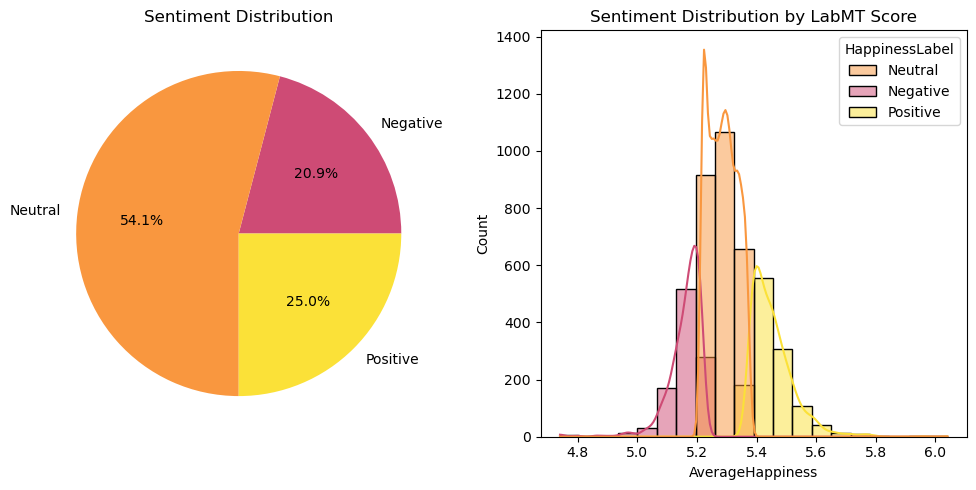

In [361]:
# Create a pie plot
labels = 'Negative', 'Neutral', 'Positive'
values = [count_neg_movie, count_neu_movie, count_pos_movie]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=three_sentiment_colors)
plt.title('Sentiment Distribution')

# Create histograms for each sentiment category
plt.subplot(1, 2, 2)
sns.histplot(data_sentiments_only_plots, x='AverageHappiness', hue='HappinessLabel', bins=20,
             palette={'Positive': three_sentiment_colors[2], 'Neutral': three_sentiment_colors[1], 'Negative': three_sentiment_colors[0]}, kde=True)
plt.title('Sentiment Distribution by LabMT Score')

plt.tight_layout()
plt.show()

Here, approximately half of the plots categorises as neutral. There are slightly fewer Negative plots (20.9%) than Positive plots. The AverageHappiness value histograms for the different distribution are also overlapping. 

It makes somewhat sense that there are more neutral plots and it also makes sense that the distributions are overlapping. 

##### **Analysis of Happiness Sentiment pr Genre**

In [362]:
# Count:
genre_counts = data_sentiments_only_plots['Genre'].value_counts()

print("Genre Counts:")
print(genre_counts)

Genre Counts:
Horror             1380
Comedy              977
Action              769
Science Fiction     515
Adventure           414
Thriller            404
Fantasy             335
Mix                  82
Name: Genre, dtype: int64


In [367]:
# Group by 'Genre' and 'HappinessLabel' and count occurrences
genre_counts = data_sentiments_only_plots.groupby(['Genre', 'HappinessLabel']).size().unstack().fillna(0)

# Drop 'Mix' genre from the DataFrame
genre_counts = genre_counts.drop('Mix', errors='ignore')

# Calculate the percentage for each genre
genre_percentage = genre_counts.div(genre_counts.sum(axis=1), axis=0) * 100

In [369]:
# The percental distribution for each genre
genre_percentage

HappinessLabel    Negative    Neutral   Positive
Genre                                           
Action           40.832250  50.585176   8.582575
Adventure        15.942029  57.971014  26.086957
Comedy            4.810645  40.429887  54.759468
Fantasy          10.447761  44.477612  45.074627
Horror           23.550725  61.376812  15.072464
Science Fiction  19.611650  60.970874  19.417476
Thriller         25.495050  63.366337  11.138614

In [370]:
# Set the order of how to plot the genres
genre_order = ['Horror', 'Comedy', 'Action', 'Science Fiction', 'Adventure', 'Thriller', 'Fantasy']

# Plotting using the sentiment colors
three_sentiment_colors_hex = ['#ce4a75', '#f8963f', '#fae038']

# Convert genre_percentage DataFrame to long format
long_df = genre_percentage.reset_index().melt(id_vars='Genre', var_name='Sentiment', value_name='Percentage')

# Plotting using Plotly Express
fig = px.bar(long_df, x="Genre", y="Percentage", color="Sentiment",
             title="Sentiment Distribution per Genre",
             labels={'Percentage': '%', 'Sentiment': 'Sentiment'},
             color_discrete_map={'Positive': three_sentiment_colors_hex[2],
                                 'Neutral': three_sentiment_colors_hex[1],
                                 'Negative': three_sentiment_colors_hex[0]},
             category_orders={"Genre": genre_order})

# Set bar mode to 'stack'
fig.update_layout(barmode='stack', title_x=0.5, legend=dict(x=1.0, y=0.5))
config = {'displayModeBar': False}

fig.show(config=config)


From the plot above, the Comedy and the Fantasy genres seems to have a larger distribution of the positive and neutral movie plots. The Horror, Action and Thriller genres on the other hand have very few positive plots.

The 10 most Positive and the 10 most negative movies based on the LabMT Sentiment:

In [378]:
# The 10 most positive movies
data_sentiments_only_plots[['Title', 'Genre', 'Rating', 'RatingLabel', 'AverageHappiness']].nlargest(10, 'AverageHappiness')

Title            Genre  Rating RatingLabel  \
2368  The Knights of the Quest        Adventure     2.2         Low   
2694   Gatlopp: Hell of a Game           Horror     7.0        High   
197      Based on a True Story         Thriller     7.2        High   
4370             Mars et Avril  Science Fiction     5.8    Moderate   
1321                   Couples           Comedy     5.5    Moderate   
2336              A Son of Man        Adventure     6.0    Moderate   
4064    A Fairy Tale After All          Fantasy     3.4         Low   
1166                  14 Phere           Comedy     6.3    Moderate   
3157     Who's Watching Oliver           Horror     5.1         Low   
2089       Seven Days of Grace           Comedy     3.4         Low   

      AverageHappiness  
2368          6.040000  
2694          5.954074  
197           5.796780  
4370          5.788267  
1321          5.770526  
2336          5.765185  
4064          5.765000  
1166          5.762400  
3157          5.755714  
2089          5.730476

... write about the movies wikipages ...

In [382]:
# The 10 most negative movies
data_sentiments_only_plots[['Title', 'Genre', 'Rating', 'RatingLabel', 'AverageHappiness']].nsmallest(10, 'AverageHappiness')

Title            Genre  Rating  \
1523                      Tales of Halloween           Horror     5.5   
1698                           My Sassy Girl           Comedy     8.0   
3154              Vampire Cleanup Department           Horror     5.6   
4550                             Dragon Head  Science Fiction     5.6   
1227                             Casino Jack           Comedy     6.2   
3470  Jolly Roger: Massacre at Cutter's Cove           Horror     3.3   
2169                        Dragon Crusaders        Adventure     2.7   
4003                             Slaughtered           Horror     2.3   
3384                               Dead Meat           Horror     4.7   
185                                 Insanity         Thriller     5.0   

     RatingLabel  AverageHappiness  
1523    Moderate          4.740000  
1698        High          4.740000  
3154    Moderate          4.740000  
4550    Moderate          4.740000  
1227    Moderate          4.786667  
3470         Low          4.802500  
2169         Low          4.861351  
4003         Low          4.865263  
3384         Low          4.890606  
185          Low          4.911579

In [385]:
# Neutral movies (scores [5.22 , 5.37])
neutral_movies = data_sentiments_only_plots[(data_sentiments_only_plots['AverageHappiness'] >= 5.22) & (data_sentiments_only_plots['AverageHappiness'] <= 5.37327)]
neutral_movies[['Title', 'Genre', 'Rating', 'RatingLabel', 'AverageHappiness']].head(3)

Title     Genre  Rating RatingLabel  AverageHappiness
0            365 Days  Thriller     3.3         Low          5.362887
4           Aswathama    Action     6.4    Moderate          5.236062
10  A Fall From Grace  Thriller     5.9    Moderate          5.364955

Now, we also want to look at the distribution of sentiment by Rating Label. So far, it seems there is no initial connection between RatingLabel and the sentiment.

##### **Analysis of Happiness Sentiment pr RatingLabel**

In [386]:
# Count:
rating_counts = data_sentiments_only_plots['RatingLabel'].value_counts()

print("RatingLabel Counts:")
print(rating_counts)

RatingLabel Counts:
Moderate    2531
High        1289
Low         1056
Name: RatingLabel, dtype: int64


In [387]:
# Group by 'rating' and 'HappinessLabel' and count occurrences
rating_counts = data_sentiments_only_plots.groupby(['RatingLabel', 'HappinessLabel']).size().unstack().fillna(0)

# Calculate the percentage for each RatingLabel
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

In [390]:
rating_percentage

HappinessLabel   Negative    Neutral   Positive
RatingLabel                                    
High            22.110163  52.288596  25.601241
Low             22.632576  55.776515  21.590909
Moderate        19.596997  54.286843  26.116160

In [391]:
# Plotting using the sentiment colors
three_sentiment_colors_hex = ['#ce4a75', '#f8963f', '#fae038']

# Convert genre_percentage DataFrame to long format
long_df = rating_percentage.reset_index().melt(id_vars='RatingLabel', var_name='Sentiment', value_name='Percentage')

# Set the order of how to plot the RatingLabels
rating_order = ['High', 'Moderate', 'Low']

# Plotting using Plotly Express
fig = px.bar(long_df, x="RatingLabel", y="Percentage", color="Sentiment",
             title="Sentiment Distribution per RatingLabel",
             labels={'Percentage': '%', 'Sentiment': 'Sentiment'},
             color_discrete_map={'Positive': three_sentiment_colors_hex[2],
                                 'Neutral': three_sentiment_colors_hex[1],
                                 'Negative': three_sentiment_colors_hex[0]},
             category_orders={"RatingLabel": rating_order})

# Set bar mode to 'stack'
fig.update_layout(barmode='stack', title_x=0.5, legend=dict(x=1.0, y=0.5))
config = {'displayModeBar': False}

fig.show(config=config)


This analysis on the RatingLabel by sentiment does not show a clear connection between the rating given to a movie and the sentiment of its text. This makes sense because a well-rated movie doesn't necessarily have a predetermined positive or negative sentiment.

**CHANGE**
For example, a thriller like "The Baader Meinhof Complex" can have a very negative-sounding plot (compound score of -0.9998) and at the same time receive a high rating (7.3). On the other hand, a fantasy movie like "Shrek 2" can get the same high rating (7.3) can have a plot with a positive sentiment (compound score of 0.9988). This means that extremely negative (-1) or positive (1) sentiment scores can both be associated with movies receiving the same rating.

A deeper look into the average happiness scores of the rating label categories:

In [393]:
# Printing the average LabMT scores of different Rating categories
high_rating_df = data_sentiments_only_plots[data_sentiments_only_plots['RatingLabel'] == 'High']
mod_rating_df = data_sentiments_only_plots[data_sentiments_only_plots['RatingLabel'] == 'Moderate']
low_rating_df = data_sentiments_only_plots[data_sentiments_only_plots['RatingLabel'] == 'Low']

print(f"Rating 'High', average LabMT score : {high_rating_df['AverageHappiness'].mean()}")
print(f"Rating 'Moderate', average LabMT score : {mod_rating_df['AverageHappiness'].mean()}")
print(f"Rating 'Low', average LabMT score : {low_rating_df['AverageHappiness'].mean()}")
print(f"Overall average LabMT score : {data_sentiments_only_plots['AverageHappiness'].mean()}")

Rating 'High', average LabMT score : 5.3006101560170125
Rating 'Moderate', average LabMT score : 5.305929322158423
Rating 'Low', average LabMT score : 5.291914926232538
Overall average LabMT score : 5.301488057340131


The mean values of the different categories are very similar.

##### **Permutation Test: Does LabMT Value Relate to RatingLabel?**

Now, it is essential to evaluate whether there is a relation between the sentiment of a movie plot, here the LabMT value, versus the Rating label. I.e. we aim to test whether the mean values of the Rating categories are significantly different on a chosen 5% confidence bound. The rating labels are still divided into the categories "High", "Moderate" and "Low". So far the sentiment analysis has not indicated that there is any relation. That we also see because the mean values of the LabMT scores are very similar as shown above.

First, the test statistic is based on the difference in means between rating label with greatest LabMT mean score("Moderate") and the rating label with smallest LabMT mean score ("Low"). Afterwards, there is done a shuffling of the LabMT value so that we keep the distribution of Rating labels and assign a random LabMT score. The p-value is calculated and tested against a significance level of 0.05.

In [395]:
# Function to calculate test statistic
def test_statistic(data_sentiments):
    # Replace with your specific test statistic calculation
    return data_sentiments.groupby('RatingLabel')['AverageHappiness'].mean().max() - data_sentiments.groupby('RatingLabel')['AverageHappiness'].mean().min()

observed_statistic = test_statistic(data_sentiments_only_plots)

# Permutation test
n_permutations = 1000
count = 0
permuted_statistics = []

for _ in range(n_permutations):
    # Shuffle the sentiment scores
    shuffled_sentiment = np.random.permutation(data_sentiments_only_plots['AverageHappiness'])
    
    # Assign shuffled scores back to dataframe
    shuffled_df = data_sentiments_only_plots.copy()
    shuffled_df['AverageHappiness'] = shuffled_sentiment
    
    # Recalculate test statistic
    permuted_statistic = test_statistic(shuffled_df)
    
    # Compare with observed statistic
    if permuted_statistic >= observed_statistic:
        count += 1

    # Store permuted statistic for histogram
    permuted_statistics.append(permuted_statistic)

# Calculate p-value
p_value = count / n_permutations

print(f"Observed statistic: {observed_statistic}")
if p_value <= 0.05:
    print(f"The highest rating label category has a significantly different mean compound score than the lowest rating label category against a random shuffling of the compound values.")
else:
    print(f"The p-value ({p_value}) indicate no significant difference in sentiment between the rating label category with the greatest vs. with the lowest average compound score against a random shuffling of the compound values.")

Observed statistic: 0.014014395925897816
The highest rating label category has a significantly different mean compound score than the lowest rating label category against a random shuffling of the compound values.


In [400]:
mmax = data_sentiments_only_plots.groupby('RatingLabel')['AverageHappiness'].mean().max()

In [399]:
mmin = data_sentiments_only_plots.groupby('RatingLabel')['AverageHappiness'].mean().min()

In [401]:
mmax - mmin

0.014014395925897816

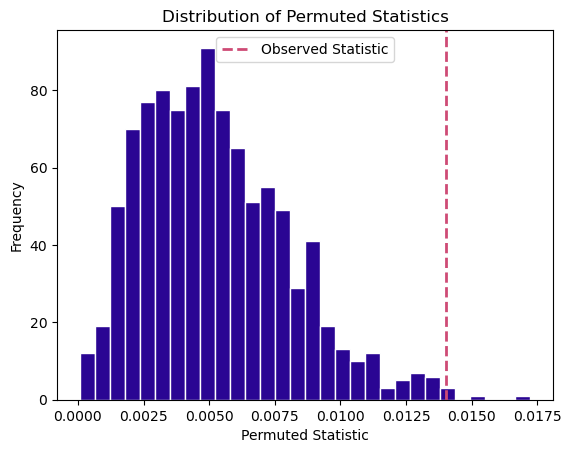

In [396]:
# Plot histogram
plt.hist(permuted_statistics, bins=30, edgecolor='white', color=colorpalette[1])
plt.axvline(x=observed_statistic, color=colorpalette[20], linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.title('Distribution of Permuted Statistics')
plt.xlabel('Permuted Statistic')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##### **Permutation Test: Does LabMT Value Relate to Genre?**